# Assignment 3: Image Classification

### By: John Reid

Import the required packages

In [126]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.image import resize_with_crop_or_pad
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# 1. Data Preprocessing

Loading the stanord dogs dataset using the tensorflow datasets. The data is then split into training and testing datasets.

In [127]:
def load_data():
    (train_data, test_data), info = tfds.load('stanford_dogs', split=['train', 'test'], with_info=True, as_supervised=True)
    return train_data, test_data, info

First, we resize the image to the desired image size, this ensures there is a consistent size of 128x128.

Next, we one hot encode the label and use a depth of 120.

In [128]:
def preprocess(image, label):
    image = tf.image.resize(image, image_size)
    image = resize_with_crop_or_pad(image, 128, 128)
    label = tf.one_hot(label, depth=120)
    return image, label

This sets the deisred image size to 128x128 and the desired validation split which is 10%

In [129]:
image_size = (128, 128)
validation_split = 0.1

In [130]:
train_data, test_data, info = load_data()

In [131]:
train_data = train_data.map(preprocess)

# 2. Model Building

Here we are designing the convolutional neural network by defining the layers we want to use along with the number of neurons and other required information.

Conv2D is the convolutional layers which extract features using 64, 128, and 256 filters which all have the size 3x3.

MaxPooling2D is the pooling layer which reduces spatial dimensions.

Dropout is the dropout layer which is applied to the fully connected layer in order to reduce overfitting.

Dense is the fully connected layer and is using 1024 neurons and relu activiation.

In [132]:
custom_model = models.Sequential()

custom_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.BatchNormalization())

custom_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.BatchNormalization())

custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
custom_model.add(layers.MaxPooling2D((2, 2)))
custom_model.add(layers.BatchNormalization())

custom_model.add(layers.Flatten())

custom_model.add(layers.Dense(512, activation='relu'))
custom_model.add(layers.Dropout(0.5))
custom_model.add(layers.BatchNormalization())

custom_model.add(layers.Dense(1024, activation='relu'))
custom_model.add(layers.Dropout(0.5))
custom_model.add(layers.BatchNormalization())

custom_model.add(layers.Dense(info.features['label'].num_classes, activation='softmax'))

custom_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_30 (Ba  (None, 63, 63, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 128)       0         
 ng2D)                                                           
                                                      

# 3. Model Training and Optimization

In [133]:
custom_model1 = custom_model
custom_model2 = custom_model
#custom_model3 = custom_model

We start by retrieving the number of training samples from the information within the dataset.

Then calculate the number of validation samples using the total training samples and the validation split specified above.

In [134]:
total_train_samples = info.splits['train'].num_examples
num_validation_samples = int(validation_split * total_train_samples)

Here we are creating a validation dataset by taking the num_validation_samples from the training data then adjusting the training dataset by using the skip function to exclude the num_validation_samples from the training set

In [135]:
val_data = train_data.take(num_validation_samples)
train_data = train_data.skip(num_validation_samples)

This is to retrive the amount of images in the validation and training sets.

In [136]:
num_val_images = tf.data.experimental.cardinality(val_data).numpy()
num_train_images = tf.data.experimental.cardinality(train_data).numpy()

print(f"Number of images in val_data: {num_val_images}")
print(f"Number of images in train_data: {num_train_images}")

Number of images in val_data: 1200
Number of images in train_data: 10800


Define the bath size for both the training and validation set.

In [137]:
batch_size = 32

batch both sets with the specified batch_size.

In [138]:
train_data = train_data.batch(batch_size)
val_data = val_data.batch(batch_size)

calculate the number of epoch steps there should be for both sets.

In [139]:
train_steps_per_epoch = len(train_data)
val_steps_per_epoch = len(val_data)

monitors the val loss value to determine if there should be early stop.

The patience of 6 tells us that without any improvement after the 6th epoch, the training will stop.

Restore best weights makes sure model weights are restored to the best values after the training is complete.

In [140]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

saves the best model which is evaluated on the val_accuracy

In [141]:
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

Optimizer is set to adam as it works well for a large array of models and is a good place to start.

The loss function is set to categorical_crossentropy as this is ideal for multi-class classification tasks like the Stanford dogs datset.

In [142]:
custom_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [143]:
history = custom_model1.fit(
    train_data,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=val_data,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
337/338 [============================>.] - ETA: 0s - loss: 5.3070 - accuracy: 0.0167

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


338/338 [==============================] - 44s 112ms/step - loss: 5.3063 - accuracy: 0.0168 - val_loss: 4.7313 - val_accuracy: 0.0375
Epoch 2/20
338/338 [==============================] - 21s 58ms/step - loss: 4.8537 - accuracy: 0.0316 - val_loss: 4.7029 - val_accuracy: 0.0325
Epoch 3/20
338/338 [==============================] - 29s 82ms/step - loss: 4.6111 - accuracy: 0.0458 - val_loss: 4.3189 - val_accuracy: 0.0592
Epoch 4/20
338/338 [==============================] - 28s 79ms/step - loss: 4.3732 - accuracy: 0.0592 - val_loss: 5.0183 - val_accuracy: 0.0342
Epoch 5/20
338/338 [==============================] - 22s 63ms/step - loss: 4.1540 - accuracy: 0.0819 - val_loss: 5.1605 - val_accuracy: 0.0325
Epoch 6/20
338/338 [==============================] - 29s 82ms/step - loss: 3.9323 - accuracy: 0.1037 - val_loss: 4.5355 - val_accuracy: 0.0617
Epoch 7/20
338/338 [==============================] - 29s 82ms/step - loss: 3.6944 - accuracy: 0.1377 - val_loss: 4.1588 - val_accuracy: 0.0992
Ep

The training accuracy has improved by a large margin which is a positive sign. However, the validation accuracy seems to not have had the same increase which could suggest overfitting or the model is not dealing with new data very well.

Optimizer changed to Nadam to see if there are improvements over the base Adam optimizer.

In [144]:
custom_model2.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [145]:
history = custom_model2.fit(
    train_data,
    steps_per_epoch=train_steps_per_epoch,
    epochs=20,
    validation_data=val_data,
    validation_steps=val_steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
338/338 [==============================] - 52s 83ms/step - loss: 2.8384 - accuracy: 0.2914 - val_loss: 4.1788 - val_accuracy: 0.1050
Epoch 2/20
338/338 [==============================] - 22s 60ms/step - loss: 2.5061 - accuracy: 0.3556 - val_loss: 4.5161 - val_accuracy: 0.0967
Epoch 3/20
338/338 [==============================] - 22s 60ms/step - loss: 2.3266 - accuracy: 0.4040 - val_loss: 4.3697 - val_accuracy: 0.1033
Epoch 4/20
338/338 [==============================] - 21s 60ms/step - loss: 2.0312 - accuracy: 0.4645 - val_loss: 4.8361 - val_accuracy: 0.0983
Epoch 5/20
338/338 [==============================] - 23s 66ms/step - loss: 1.7121 - accuracy: 0.5379 - val_loss: 4.7430 - val_accuracy: 0.0667
Epoch 6/20
338/338 [==============================] - 28s 79ms/step - loss: 1.5607 - accuracy: 0.5750 - val_loss: 4.6547 - val_accuracy: 0.1100
Epoch 7/20
338/338 [==============================] - 23s 64ms/step - loss: 1.2845 - accuracy: 0.6410 - val_loss: 4.7944 - val_accuracy:

The accuracy of this model is better than the last indicating it is better fitting with the training data. Unfortunatelly, the val_accuracy is still not improving which continues to suggest possible overfitting.

The Optimizer Nadam was used as it yielded a higher accuracy with the categorical_crossentropy loss function.

Loss function was changed to binary_crossentropy out of curiosity to see if any improvements can be made. I know this can not be used for our final model which is why it was commented out, but I wondered how putting the multi-class classification problem through a binary classification method would affect it.

In [146]:
#custom_model3.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [147]:
#history = custom_model3.fit(
#    train_data,
#    steps_per_epoch=train_steps_per_epoch,
#    epochs=20,
#    validation_data=val_data,
#    validation_steps=val_steps_per_epoch,
#    callbacks=[early_stopping, model_checkpoint]
#)

This model achieves the highest accuracy by a large margin but does still struggle with the problem of overfitting. It is interesting to see how this greatly improves the accuracy.

# 4. Evaluation

Load the best model

In [148]:
best_model = load_model('best_model.h5')

This function is used in order to get the predictions for the data along with the true labels.

In [149]:
def get_predictions(model, data):
    predictions = []
    true_labels = []

    for batch in data:
        images, labels = batch
        predictions_batch = model.predict(images)
        predictions.extend(np.argmax(predictions_batch, axis=1))
        true_labels.extend(np.argmax(labels, axis=1))

    return np.array(predictions), np.array(true_labels)

Retrieve the predictions for both the custom models

In [150]:
predictions_one, true_labels_one = get_predictions(custom_model1, val_data)
predictions_two, true_labels_two = get_predictions(custom_model2, val_data)

1/1 [==============================] - 0s 22ms/step


Create the confusion matrices

In [151]:
conf_matrix_one = confusion_matrix(true_labels_one, predictions_one)
conf_matrix_two = confusion_matrix(true_labels_two, predictions_two)

Plot the confusion matrices

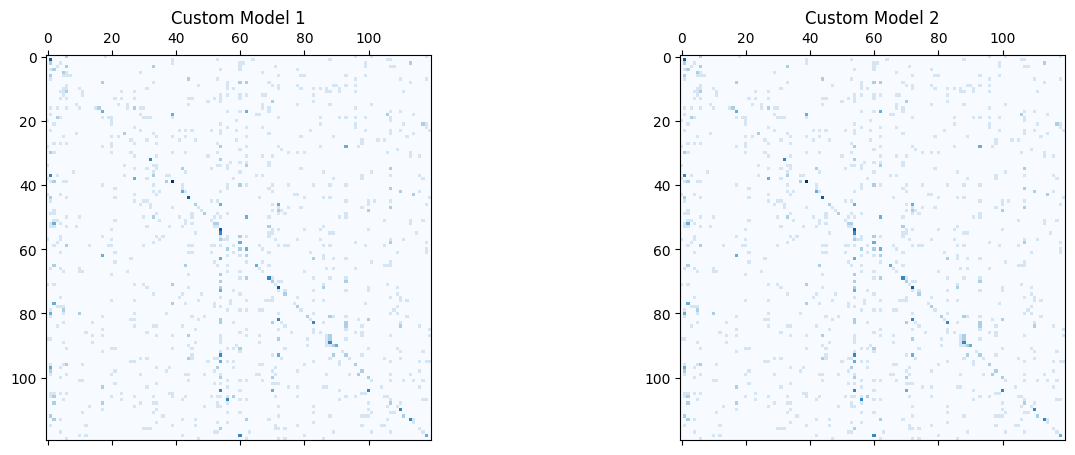

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].matshow(conf_matrix_one, cmap='Blues')
axes[0].set_title('Custom Model 1')
axes[1].matshow(conf_matrix_two, cmap='Blues')
axes[1].set_title('Custom Model 2')
plt.show()

In [153]:
accuracy_one = accuracy_score(true_labels_one, predictions_one)
accuracy_two = accuracy_score(true_labels_two, predictions_two)

print(f'Accuracy for Custom Model 1: {accuracy_one:.4f}')
print(f'Accuracy for Custom Model 2: {accuracy_two:.4f}')

Accuracy for Custom Model 1: 0.1050
Accuracy for Custom Model 2: 0.1050


# 5. Write-up

### Challenges

1) One of the main problems faced while creating the models was achieving a good accuracy. The only way for me to achieve a good accuracy was to use binary crossentropy which is not applicable in this scenario as it is not a binary classification problem. To achieve the best accuracy I did using a multi-class problem required testing different layers and changing the optimizer and loss function to fit the model better and still did not yield a very good accuracy

2) Overfitting was another issue faced. No matter what parameters were inputted, there was no increase in the val_Accuracy which could indecate the model was overfit. Even when the loss function was changed to the binary classification, the model still struggled with overfitting.

3) Computational power was the final issue. These models took a long time to run and as the models improved they took more and more time to run. These can be effective in this scenario but may not work very well in a business setting.

### What worked and what did not

1) the optimizer was best when set to Nadam. Initally, I tried the adam optimizer as it was a good general optimizer. However, the results achievied were not ideal so I tried using other optimizers and came across Nadam. This is an extension of Adam and was able to achieve a higher accuracy.

2) The loss function yielded the highest accuracy when it was set to binary_crossentropy but this cant be used given the dataset. For this reason the loss function that must be used should be categorical_crossentropy. Unfortunately the accuracy achieved with this loss function is poor and also struggles with overfitting.

3) Setting the early stop helped with the computational problem greatly. In some cases only 6 epochs would run which greatly reduced the time required to run the models. Without this the time required would be much higher with no meaningful improvements to the models.